In [2]:
#importing necessary libraries
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
#plotting using traditional calculation
from mpl_toolkits import mplot3d
from matplotlib import cm
import scipy.optimize

ModuleNotFoundError: No module named 'sklearn'

In [19]:
# input disparity map to be rectified
left_image = cv2.imread('left_image1.png')
right_image = cv2.imread('rightt_image1.png')

height = left_image.shape[0]
width = left_image.shape[1]

left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

In [20]:
#input fundamental matrix from camera
max_disparity = 96

H1 = np.array([[ 1.00047384e+00, -9.21142380e-04 , 1.05547668e+01],
 [-8.98002546e-04 , 9.98893992e-01, -5.28518968e-01],
 [ 7.41705741e-07, -3.17840628e-06 , 1.00062402e+00]])

H2 = np.array([[ 1.00499352e+00 , 2.38408626e-03 ,-9.01707400e+00],
 [ 2.31503605e-03 , 1.00108968e+00, -3.93138454e+00],
 [ 7.67580780e-06 , 3.18005952e-06 , 9.93872447e-01]])

In [21]:
# rectify image
left_img_rect = cv2.warpPerspective(left_image_gray, H1, left_image_gray.shape[::-1],
                                    cv2.INTER_CUBIC +
                                    cv2.WARP_FILL_OUTLIERS +
                                    cv2.WARP_INVERSE_MAP)

right_img_rect = cv2.warpPerspective(right_image_gray, H2, right_image_gray.shape[::-1],
                                    cv2.INTER_CUBIC +
                                    cv2.WARP_FILL_OUTLIERS +
                                    cv2.WARP_INVERSE_MAP)
lz_rectified = cv2.hconcat([left_img_rect, right_img_rect])

In [22]:
# disparity caalculation
win_size = -2
min_disp =-2
max_disp =0
num_disp =70 # Needs to be divisible by 16
stereoProcessor = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=5,
    uniquenessRatio=5,
    speckleWindowSize=10,
    speckleRange=10,
    disp12MaxDiff=10,
    P1=10,
    P2=700,
    preFilterCap = 10,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
)

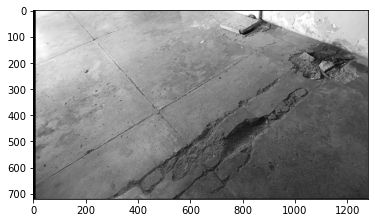

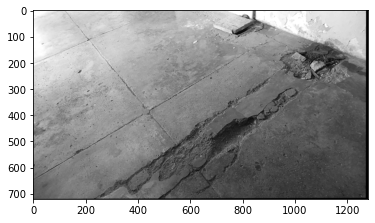

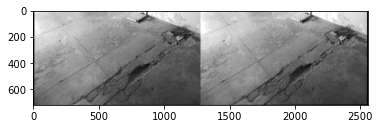

[[209 214 224 ... 541 -48 -48]
 [206 209 214 ... 541 -48 -48]
 [204 204 203 ... 569 -48 -48]
 ...
 [736 736 740 ... -48 -48 -48]
 [824 816 816 ... -48 -48 -48]
 [824 816 816 ... -48 -48 -48]]


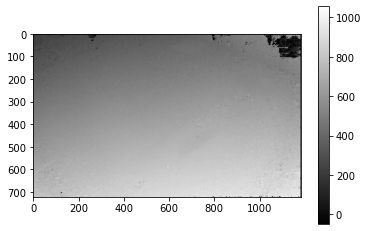

In [23]:
# show disparity
dis = stereoProcessor.compute(left_img_rect, right_img_rect)
# disparity = stereoProcessor.compute(right_img_rect, left_img_rect)

dis = dis[0:dis.shape[0], max_disparity:dis.shape[1]]

height = left_image.shape[0]
width = left_image.shape[1]
# print(disparity)

plt.imshow(left_img_rect, "gray")
plt.show()
plt.imshow(right_img_rect,"gray")
plt.show()
plt.imshow(lz_rectified,"gray")
plt.show()
print(dis)
plt.imshow(dis, "gray")
plt.colorbar()
plt.show()

[[ 0 88 88 ...  0  0  0]
 [ 0 88 88 ...  0  0  0]
 [88 88 88 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


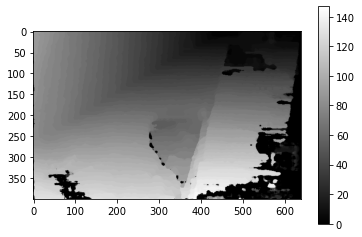

In [24]:
disparity = np.load('image_0.npy')
print(disparity)
plt.imshow(disparity, "gray")
plt.colorbar()
plt.show()

[[ 59  59  59 ...   0   0   0]
 [ 59  59  59 ...   0   0   0]
 [ 59  59  59 ...   0   0   0]
 ...
 [126 126 144 ...   0   0   0]
 [144 144 144 ...   0   0   0]
 [ 51 144 144 ...   0   0   0]]


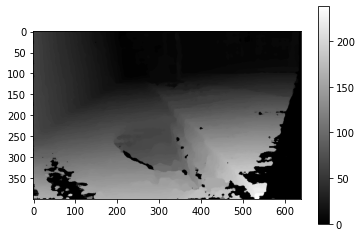

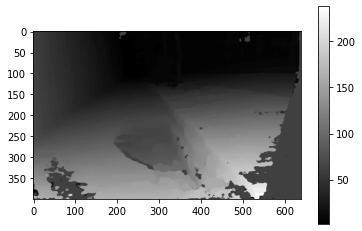

In [3]:
disparity = np.load('depth_image_4.npy')
print(disparity)
plt.imshow(disparity, "gray")
plt.colorbar()
plt.show()
sum_dis = 0
disp_no =0
for i in range(disparity.shape[0]):
    for j in range(disparity.shape[1]):
        sum_dis= sum_dis + disparity[i][j]
        disp_no = disp_no + 1
avg_dis = sum_dis/disp_no
for i in range(disparity.shape[0]):
    for j in range(disparity.shape[1]):
        if(disparity[i][j] == 0):
            disparity[i][j] = avg_dis
plt.imshow(disparity, "gray")
plt.colorbar()
plt.show()

In [26]:
image_centre_h = disparity.shape[0]/2
image_centre_w = disparity.shape[1]/2

''' Projects points from 2d to 3d using disparity to calculate Z coordinates'''

points = []

f = 800.74853515625
B = 0.075

height1, width1 = disparity.shape[:2]

# assume a minimal disparity of 2 pixels is possible to get Zmax
# and then get reasonable scaling in X and Y output

#Zmax = ((f * B) / 2)
a=0
x3d=[]
y3d=[]
z3d=[]

for y in range(height1):# 0 - height is the y axis index
    for x in range(width1):# 0 - width is the x axis index

        # if we have a valid non-zero disparity
        if (disparity[y,x] > 0 or disparity[y,x] < 0):

            # calculate corresponding 3D point [X, Y, Z]

            Z = (f * B) / disparity[y,x]

            X = ((x - image_centre_w) * B) / disparity[y,x]
            Y = ((y - image_centre_h) * Z) / disparity[y,x]

            # add to points
            x3d.append(X)
            y3d.append(Y)
            z3d.append(Z)

#             if(left_img_rect.size > 0):
#                 points.append([X,Y,Z,left_img_rect[y,x]])
#             else:
            points.append([X,Y,Z])

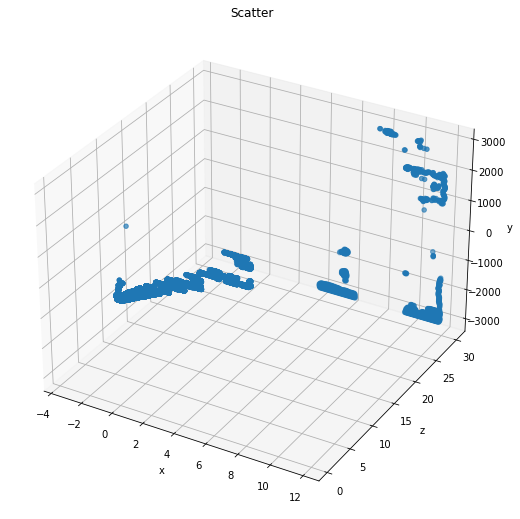

In [28]:
fig = plt.figure(figsize =(14, 9))
# ax = plt.axes(projection ='3d')
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Scatter')
# ax.plot_surface(z1,x1,y1,linewidth=0, antialiased=False, shade = True, alpha = 0.5, facecolors=cm.viridis(Z1))
# surf3 = ax.plot_surface(z1, x1, y1,
#                        cmap = my_cmap,
#                        edgecolor ='none')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
ax.scatter(x3d, z3d, y3d)
# fig.colorbar(surf3, shrink=0.5, aspect=5)
plt.show()